In [5]:
import os
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from Plane import Plane
from DDPG_lib.ddpg import Agent

In [6]:
figures_dir = "Plots"
if not os.path.exists(figures_dir):
        os.mkdir(figures_dir) 

def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, scores, alpha=1,label="Nagrody za epizod")
    plt.plot(x, running_avg, linewidth=2, label="Średnia krocząca z 50")
    plt.xlim(1,len(x))
    plt.xlabel("Epizody", fontsize=12 )
    plt.ylabel("Nagrody", fontsize=12 )
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(figures_dir, 'learning_curve.png'))


In [9]:
def learn_plane(env, chkpt_dir='DDPG_checkpoints', model_dir='DDPG_models'):
    start_time = time.time()

    agent = Agent(input_dims=4, env=env,lr_a=0.001, lr_c=0.002,
            n_actions=1, action_bound_range=np.deg2rad(25), std_noise=0.2, chkpt_dir=chkpt_dir, model_dir=model_dir)
    
    n_games = 5
    n_steps = 50
    
    best_score_avg = -50
    best_score = -50
    score_history = []

    for episode in range(n_games):
        obs = env.reset()
        done = False
        score = 0
        evaluate = False

        for step in range (n_steps):
            action = agent.choose_action(obs, evaluate)
            new_obs, reward, done, info = env.step(action)
            score += reward
            agent.remember(obs, action, reward, new_obs, done)

            agent.learn()
            
            obs = new_obs
            if done:
                print(step)
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-10:]) 

        if avg_score > 0.8*best_score_avg and score > 0.75*best_score:
            best_score_avg = avg_score
            best_score = score
            agent.save_weights(episode)

        print('episode ', episode, 'score %.1f' % score, 'avg score %.1f' % avg_score)

    # Save final model 
    agent.save_models()
    # Plot learning curve
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history)
    #Print learning time 
    end_time = time.time()
    print("Time:", end_time-start_time)

    return agent

episode  0 score -504.0 avg score -504.0
28
... saving weights ...
episode  1 score -242.5 avg score -373.2
8
... saving weights ...
episode  2 score -79.5 avg score -275.3
9
episode  3 score -212.9 avg score -259.7
8
episode  4 score -98.9 avg score -227.6
... saving models ...
Time: 2.7792296409606934


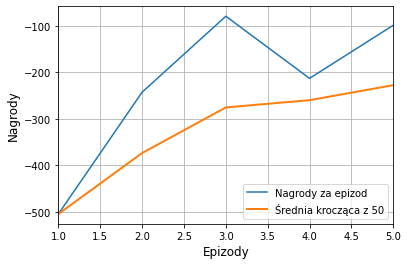

In [10]:
env = Plane(data_path="Data/Mp(10alpha).csv", reward_type="L1+Gauss", evaluate=False)
agent = learn_plane(env)